In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
# import os
# from PIL import Image

# # 1. DEFINE YOUR FOLDERS
# # The folder containing your organized constellation subfolders
# input_folder = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\Constellations' 
# # The main folder where cropped subfolders will be created
# output_folder = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\FinalConstellations' 

# # 2. DEFINE CROP VALUES (in pixels)
# pixels_to_crop_top = 90
# pixels_to_crop_bottom = 100
# pixels_to_crop_left = 120
# pixels_to_crop_right = 0

# # --- SCRIPT START ---
# # Create the main output folder if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# print("Starting image cropping...")

# # Loop through each constellation subfolder in the input directory
# for constellation_name in os.listdir(input_folder):
#     constellation_input_path = os.path.join(input_folder, constellation_name)
#     constellation_output_path = os.path.join(output_folder, constellation_name)

#     # Check if it's actually a directory
#     if os.path.isdir(constellation_input_path):
#         # Create a corresponding output subfolder
#         if not os.path.exists(constellation_output_path):
#             os.makedirs(constellation_output_path)
        
#         print(f"Processing folder: {constellation_name}")

#         # Loop through all the image files in the current constellation subfolder
#         for filename in os.listdir(constellation_input_path):
#             if filename.endswith(('.png', '.jpg', '.jpeg')):
#                 try:
#                     img_path = os.path.join(constellation_input_path, filename)
#                     img = Image.open(img_path)
                    
#                     width, height = img.size
#                     crop_box = (
#                         pixels_to_crop_left, 
#                         pixels_to_crop_top, 
#                         width - pixels_to_crop_right, 
#                         height - pixels_to_crop_bottom
#                     )
                    
#                     cropped_img = img.crop(crop_box)
#                     cropped_img.save(os.path.join(constellation_output_path, filename))

#                 except Exception as e:
#                     print(f"Could not process {filename}. Error: {e}")

# print(f"\nCropping complete! Your organized, cropped images are in '{output_folder}'.")

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "FinalConstellations",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size= BATCH_SIZE
)

Found 433 files belonging to 8 classes.


In [5]:
class_names= dataset.class_names

In [19]:
class_names

['CanisMajor',
 'Cassiopeia',
 'Crux',
 'Leo',
 'Orion',
 'Scorpius',
 'UrsaMajor',
 'UrsaMinor']

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size= len(ds)

    if(shuffle):
        ds= ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split* ds_size)
    val_size= int(val_split* ds_size)

    train_ds= ds.take(train_size)

    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [8]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.applications import EfficientNetB0

n_classes= 8
INPUT_SHAPE= (IMAGE_SIZE,IMAGE_SIZE,3)

data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
],name="data_augmentation")

base_model= EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3),
)

model= keras.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes,activation="softmax"),
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,132,075 (15.76 MB)

 Trainable params: 4,090,052 (15.60 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
print("--- Starting Phase 1: Initial Training ---")
# Freeze the base model so only the new layers are trained
base_model.trainable = False

# Compile the model with a standard learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define the learning rate scheduler callback
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7
)

# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
)


--- Starting Phase 1: Initial Training ---
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.1899 - loss: 2.0806 - val_accuracy: 0.4062 - val_loss: 1.6872 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3939 - loss: 1.7004 - val_accuracy: 0.6875 - val_loss: 1.1908 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5146 - loss: 1.4239 - val_accuracy: 0.7500 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5709 - loss: 1.2628 - val_accuracy: 0.7188 - val_loss: 0.8141 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5845 - loss: 1.1894 - val_accuracy: 0.7188 - val_loss: 0.8109 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4926 - loss: 1.2491 - val_accuracy: 0.7500 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accur

In [12]:
model.save('true_model_version_1_constellation.keras')

In [13]:
print("\n--- Evaluating Final Model ---")
final_loss, final_accuracy = model.evaluate(test_ds)
print(f"Final Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_accuracy*100:.2f}%")


--- Evaluating Final Model ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8646 - loss: 0.4583
Final Test Loss: 0.4661
Final Test Accuracy: 85.94%


first image to predict
first image's actual label: Cassiopeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Cassiopeia


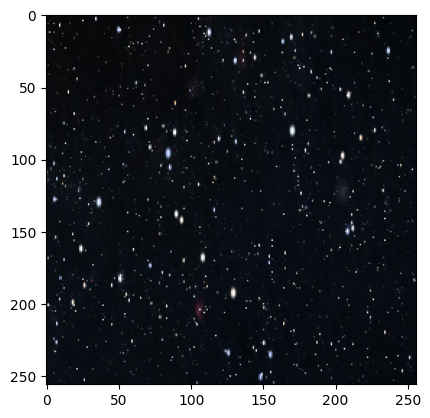

In [16]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Corrected Snippet ---

# 1. Define the path to your test image
img_path = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\Orion.jpg'
# This loads the image and ensures it's the 256x256 size your model expects.
img_tensor = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

# 3. Convert the image to a NumPy array
# This gives it the shape (256, 256, 3)
img_array = image.img_to_array(img_tensor)

# 4. Add the batch dimension
# The shape is now (1, 256, 256, 3), which the model can accept.
img_batch = np.expand_dims(img_array, axis=0)

# 5. Make the prediction
batch_prediction = model.predict(img_batch)

# 6. Get the final result
predicted_class_index = np.argmax(batch_prediction[0])
predicted_class_name = class_names[predicted_class_index]

print(f"The predicted constellation is: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The predicted constellation is: CanisMajor
